# Прогноз оттока клиентов

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# Цель проекта

Целью проекта является создание модели, которая будет предсказывать угрозу оттока клиентов компании «Ниединогоразрыва.ком». 

Предполагается, что клиентам, планирующим уйти, будут предложены промокоды и специальные условия. Исходя из этого метрикой качества модели будет являться AUC_ROC, поскольку для задачи важно как не дать лишние скидки клиентам, которые не планируют уходить, так и удержать клиентов.

Целевое значение метрики - от 0.85.

# План работы

1. Объединить выборки, провести анализ данных, проверить признаки на мулитиколлинеарность, проанализировать наличие дисбаланса. Создать целевой признак, признаки для клиентов, использующих интеренет и телефонию. Разбить данные на обучающую и тестовую выборки.

2. Проверить несколько моделей:
- случайный лес;
- линейная регрессия;
- градиентный бустинг.

Гиперпараметры подобрать с помощью RandomizedSearchCV. Перед построением модели провести кодирование признаков, категориальные признаки кодируются с помощью OHE, провести нормализацию числовых признаков.

3. Выбрать модель с наилучшей метрикой AUC_ROC, проверить ее на тестовой выборке. Визуализировать важность признаков.

## Подготовка данных

### Загрузка данных и ознакомление

In [1]:
!python -m pip install phik

     |████████████████████████████████| 679 kB 1.2 MB/s eta 0:00:01


In [2]:
# загрузим необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

import phik

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# зададим константное значение RANDOM_STATE
RANDOM_STATE = 270223

In [4]:
# загрузим данные
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [5]:
# создадим функцию для вывода общей информации по каждой выборке
def first_view(data):
    print(data.info())
    print('')
    print('Количество дубликатов строк:', data['customerID'].duplicated().sum())
    display(data.head())
    display(data.describe(include='all'))

In [6]:
first_view(contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

Количество дубликатов строк: 0


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,5,3,2,4,NaN,6531
top,1855-CFULU,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,20.2
freq,1,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


In [7]:
first_view(personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

Количество дубликатов строк: 0


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,1855-CFULU,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


In [8]:
first_view(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

Количество дубликатов строк: 0


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,5067-XJQFU,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [9]:
first_view(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

Количество дубликатов строк: 0


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,1855-CFULU,No
freq,1,3390


Мы загрузили данные, всего для анализа есть 7043 объекта. 

Дубликаты не обнаружены.

Информация о договорах содержит данные о начале пользования услугами и о конце пользования услугами (на основе этих данных определяется целевой признак). Таже есть данные о типе и способе оплаты, об  общих и ежемесячных  тратах. Тип данных некорректный, его надо заменить на datetime (колонки BeginDate  и EndDate), float (колонка TotalCharges) и category (колонки Type, PaperlessBilling, PaymentMethod).

Персональные данные клиента содержат иформацию о поле, о наличии супруга и иждевенцев, о наличии пенсионного статуса. Тип данных также надо заменить на category во всех колонках, кроме customerID.

Информация об интернет-услугах и об услугах телефонии есть не для всех клиентов (5517 наблюдений в данных об интернет-услугах  и 6361 наблюдений в данных об услугах телефонии). Возможно, не все клиенты одновременно пользуются и телефонией и интернет-услугами. Тип данных также надо заменить на category во всех колонках, кроме customerID.

### Предобработка данных

In [10]:
# переименуем колонки
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

for column in list(contract):
    contract = contract.rename(columns={column: camel_to_snake(column)})
    
for column in list(personal):
    personal = personal.rename(columns={column: camel_to_snake(column)})

for column in list(internet):
    internet = internet.rename(columns={column: camel_to_snake(column)})

for column in list(phone):
    phone = phone.rename(columns={column: camel_to_snake(column)})

In [11]:
# приведем к типу дата даты начала и окончания пользования услугами
contract['begin_date'] = pd.to_datetime(contract['begin_date'])
contract['end_date'] = pd.to_datetime(contract['end_date'], errors='coerce')

In [12]:
# приведем к типу float общую сумму, потраченную на услуги
contract.loc[(contract['total_charges'] == ' '), 'total_charges'] = '0'
contract['total_charges'] = contract['total_charges'].astype('float')

In [13]:
# проверим данные с 0 в колонке TotalCharges
contract.query('total_charges == 0')

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,0.0
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,0.0
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,0.0
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,0.0
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,0.0
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,0.0
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,0.0
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,0.0
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,0.0
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,0.0


Колонка total_charges не заполнена для пользователей, подключившихся в месяце, на который произведена выгрузка данных.

In [14]:
# заполним колонку total_charges, равную 0, значением monthly_charges
contract.loc[(contract['total_charges'] == 0), 'total_charges'] = contract['monthly_charges']

In [15]:
# приведем колонки с категориальными данными к корректному типу
contract[['type', 'paperless_billing', 'payment_method']] = \
    contract[['type', 'paperless_billing', 'payment_method']].astype('category')

In [16]:
personal[['gender', 'senior_citizen', 'partner', 'dependents']] = \
    personal[['gender', 'senior_citizen', 'partner', 'dependents']].astype('category')

In [17]:
internet[['internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']] = \
    internet[['internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']].astype('category')

In [18]:
phone['multiple_lines'] = phone['multiple_lines'].astype('category')

Мы привели данные к корректным категориям. Пропуски в колонке total_charges заполнили значением колонки monthly_charges, поскольку данные были не указаны для клиентов, которые подключились в месяце, в котором произведена выгрузка данных. 

### Первичный анализ данных

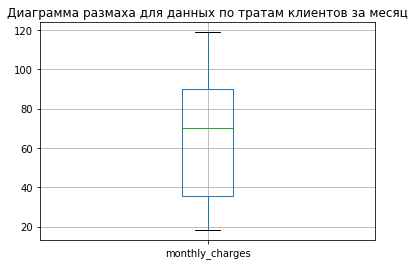

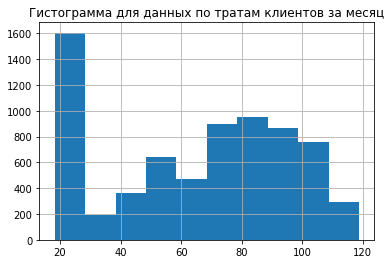

In [19]:
# построим boxplot и гистограмму для признака monthly_charges 
plt.title('Диаграмма размаха для данных по тратам клиентов за месяц')
contract.boxplot(column='monthly_charges')
contract.hist(column='monthly_charges')
plt.title('Гистограмма для данных по тратам клиентов за месяц');

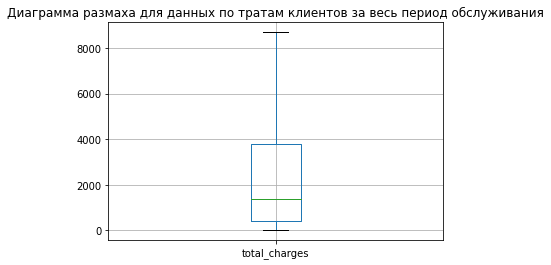

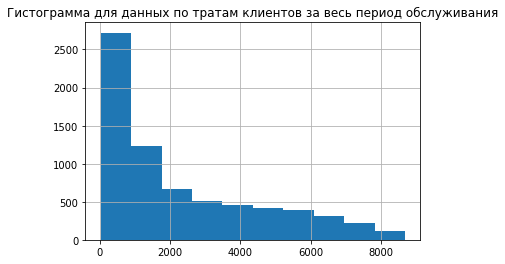

In [20]:
# построим boxplot и гистограмму для признака total_charges 
plt.title('Диаграмма размаха для данных по тратам клиентов за весь период обслуживания')
contract.boxplot(column='total_charges')
contract.hist(column='total_charges')
plt.title('Гистограмма для данных по тратам клиентов за весь период обслуживания');

In [21]:
contract['total_charges'].min()

18.8

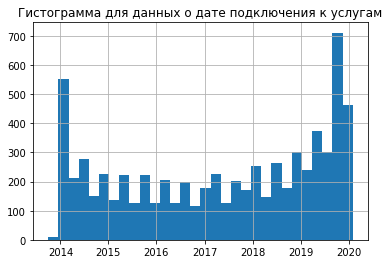

In [22]:
# построим гистограмму для признака begin_date
plt.title('Гистограмма для данных о дате подключения к услугам')
contract['begin_date'].hist(bins=30);

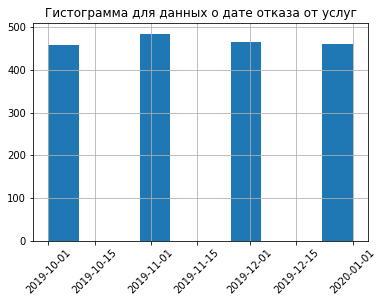

In [23]:
# построим гистограмму для признака end_date
plt.title('Гистограмма для данных о дате отказа от услуг')
plt.xticks(rotation=45)
contract['end_date'].hist();

Мы построили диаграммы размаха для данных о тратах клиентов за месяц и за весь период, выбросы не обнаружены. За месяц клиент тратит от 20 до 120 долларов. Большое количество клиентов тратит примерно 20 долларов в месяц. 

В выборке представлены данные о подключениях с конца 2013 по начало 2020 года, помесячно. Данные об отключениях есть за 4 даты с конца 2019 года.

Другие признаки в выборках категориальные, количество категория небольшое, в основном это бинарные признаки, есть признаки с 3 или 4 категориями.

## Исследовательский анализ данных

### Объединение выборок и подготовка новых признаков

In [24]:
# объединим датасеты
df = contract.merge(right=personal, on='customer_id', how='left')
df = df.merge(right=internet, on='customer_id', how='left')
df = df.merge(right=phone, on='customer_id', how='left')

In [25]:
# проверим, что данные не потерялись
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   category      
 4   paperless_billing  7043 non-null   category      
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   category      
 9   senior_citizen     7043 non-null   category      
 10  partner            7043 non-null   category      
 11  dependents         7043 non-null   category      
 12  internet_service   5517 non-null   category      
 13  online_security    5517 non-null   category      
 14  online_b

In [26]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [27]:
# заполним пропуски константным значением
columns = ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines']
for col in columns:
    df[col] = df[col].cat.add_categories(['not use'])
    df[col].fillna(value='not use', inplace=True)

In [28]:
# проверим правильность заполнения
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   category      
 4   paperless_billing  7043 non-null   category      
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   category      
 9   senior_citizen     7043 non-null   category      
 10  partner            7043 non-null   category      
 11  dependents         7043 non-null   category      
 12  internet_service   7043 non-null   category      
 13  online_security    7043 non-null   category      
 14  online_b

In [29]:
# создадим колонку для целевого признака
df.loc[(df['end_date'].isna() == False), 'is_exited'] = 1
df.loc[(df['end_date'].isna() == True), 'is_exited'] = 0
df['is_exited'] = df['is_exited'].astype('int8')

In [30]:
# создадим признаки использования интернет-сервиса и телефонии
df.loc[(df['online_backup'] == 'not use'), 'is_internet'] = 0
df.loc[(df['online_backup'] != 'not use'), 'is_internet'] = 1
df.loc[(df['multiple_lines'] == 'not use'), 'is_phone'] = 0
df.loc[(df['multiple_lines'] != 'not use'), 'is_phone'] = 1
df['is_internet'] = df['is_internet'].astype('int8')
df['is_phone'] = df['is_phone'].astype('int8')

In [31]:
# проверим созданные колонки
print(df['is_exited'].sum(), df['is_internet'].sum(), df['is_phone'].sum())

1869 5517 6361


In [32]:
# создадим признак длительности пользования услугами
last_date  = df['begin_date'].max()
df['duration_of_use'] = df.apply(lambda x: last_date - x['begin_date'] 
                                 if x['is_exited'] == 0 
                                 else x['end_date'] - x['begin_date'], axis=1)
# df['duration_of_use'] = round(df['duration_of_use'] / np.timedelta64(1, "M"), 2)
df['duration_of_use'] = df['duration_of_use'].dt.days

In [33]:
# проверим
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,is_exited,is_internet,is_phone,duration_of_use
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,Yes,No,No,No,No,not use,0,1,0,31
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,Male,0,...,No,Yes,No,No,No,No,0,1,1,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,Yes,No,No,No,No,No,1,1,1,61
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,No,Yes,Yes,No,No,not use,0,1,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,No,No,No,No,No,1,1,1,61


Мы объединили выборки. Создали целевой признак. Поскольку услугами интернета и телефонии пользуются не все клиенты, в объединенном датасете появились пропуски, мы заполнили их индикаторных значением. Также мы создали новые  признаки: пользуется ли клиент телефонией и интернет-услугами, продолжительность пользования услугами.

В колонке с данными о дате отключения остались пропуски, но мы не будем использовать этот признак в моделях,так как это прямая информация о значении целевого признака. 

### Анализ объединенных данных

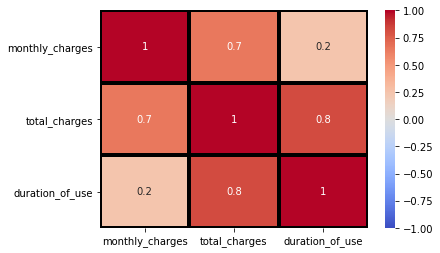

In [34]:
# построим матрицу корреляции Пирсона для числовых признаков
interval_cols=['monthly_charges', 'total_charges', 'duration_of_use']
sns.heatmap(df[interval_cols].corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center= 0,
            cmap= 'coolwarm', linewidths=3, linecolor='black');

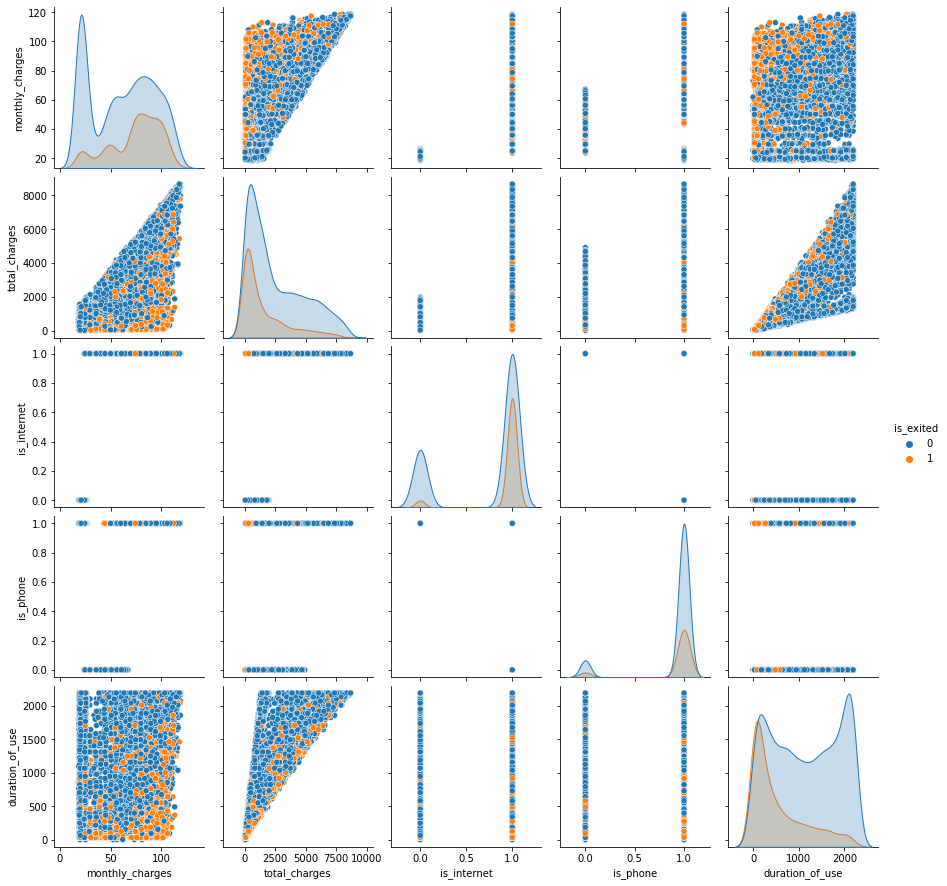

In [35]:
# построим матрицу диаграмм рассеяния для числовых признаков с визуализацией целевого признака
sns.pairplot(df, hue='is_exited')
plt.show();

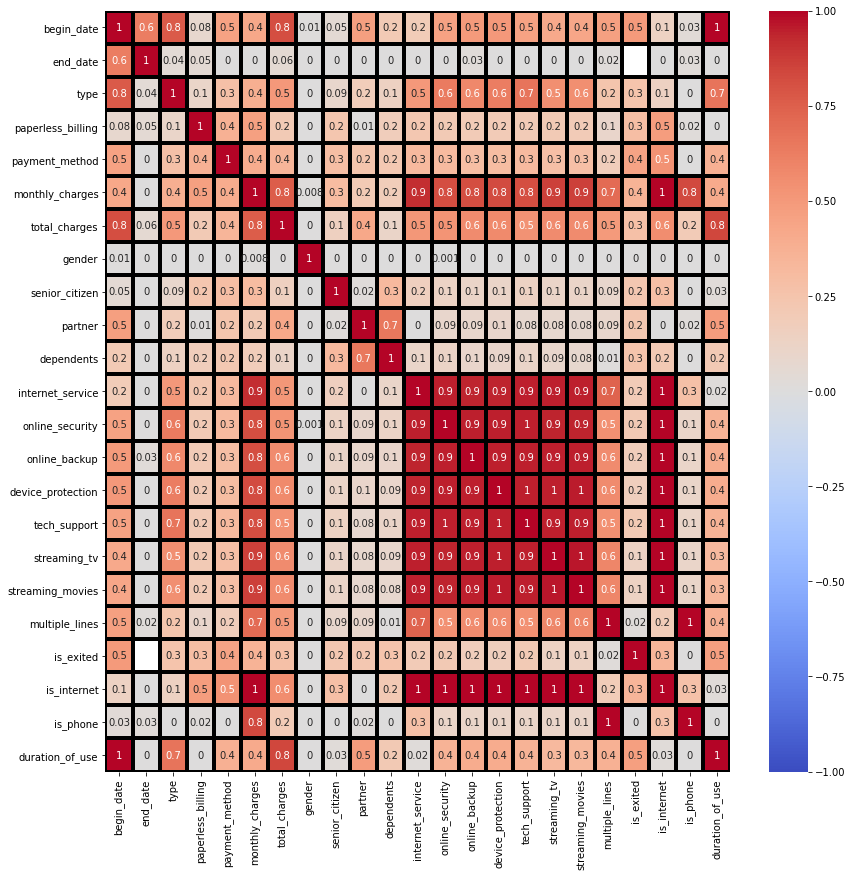

In [36]:
# построим матрицу корреляции Хи-квадрат
plt.figure(figsize=(14, 14))
sns.heatmap(phik.phik.phik_matrix(df.iloc[:, 1:],
                                  interval_cols=interval_cols),
            annot=True, fmt='.1g', vmin=-1, vmax=1, center= 0,
            cmap= 'coolwarm', linewidths=3, linecolor='black');

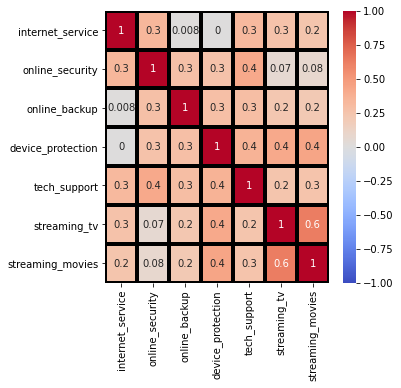

In [37]:
# построим матрицу корреляции Хи-квадрат отдельно для анализа корреляции данных об используемых интеренет-сервисах
plt.figure(figsize=(5, 5))
sns.heatmap(phik.phik.phik_matrix(internet.iloc[:, 1:]),
                                  annot=True, fmt='.1g', vmin=-1, vmax=1, center= 0,
            cmap= 'coolwarm', linewidths=3, linecolor='black');

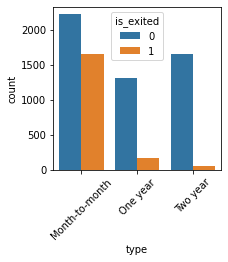

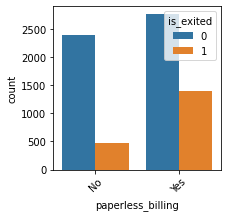

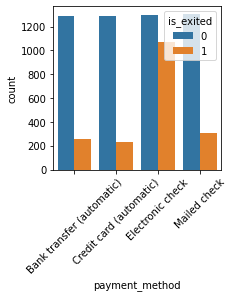

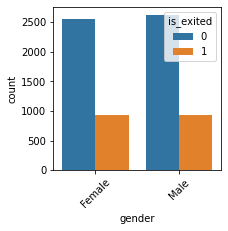

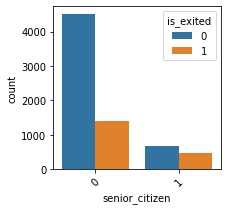

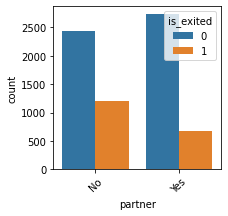

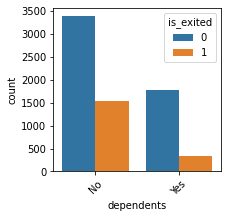

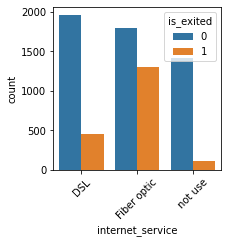

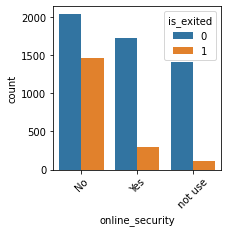

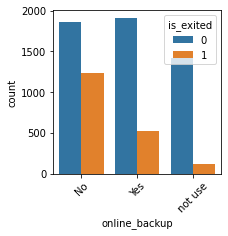

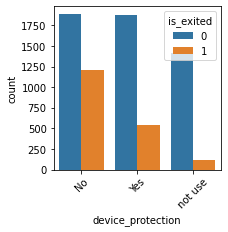

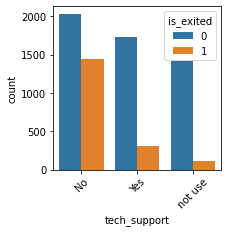

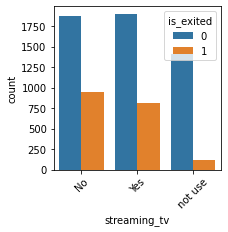

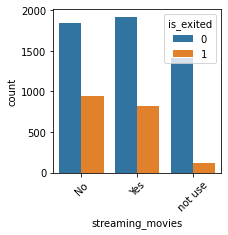

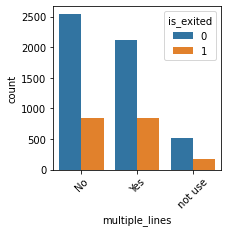

In [38]:
# визуализируем распределение отключившихся клиентов по категориальным признакам
categorial = ['type', 'paperless_billing', 'payment_method',
              'gender', 'senior_citizen', 'partner', 'dependents',
              'internet_service', 'online_security', 'online_backup',
              'device_protection', 'tech_support', 'streaming_tv',
              'streaming_movies', 'multiple_lines']


for cat in categorial:
    plt.figure(figsize=(3, 3))
    plt.xticks(rotation=45)
    sns.countplot(x=cat, hue='is_exited', data=df)
    plt.show(); 

In [39]:
# посчитаем долю отключившихся среди пользователей интернет-услуг
internet_exited = df.groupby(by='is_internet')['is_exited'].agg(['count', 'sum'])
internet_exited['rate'] = round(internet_exited['sum'] / internet_exited['count'], 2)
print('Доля отключившихся среди пользователей интернет-услуг')
display(internet_exited)
# посчитаем долю отключившихся среди пользователей услуг телефонии
phone_exited = df.groupby(by='is_phone')['is_exited'].agg(['count', 'sum'])
phone_exited['rate'] = round(phone_exited['sum'] / phone_exited['count'], 2)
print('Доля отключившихся среди пользователей услуг телефонии')
display(phone_exited)

Доля отключившихся среди пользователей интернет-услуг


,count,sum,rate
is_internet,,,
0,1526,113.0,0.07
1,5517,1756.0,0.32


Доля отключившихся среди пользователей услуг телефонии


,count,sum,rate
is_phone,,,
0,682,170.0,0.25
1,6361,1699.0,0.27


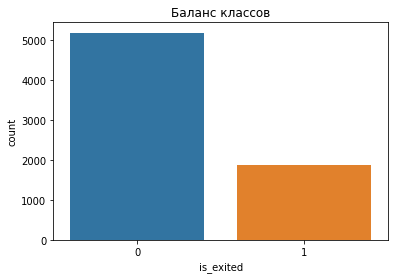

In [40]:
# проверим данные на дисбаланс классов
plt.title('Баланс классов')
sns.countplot(x=df['is_exited'])
plt.show();

Анализ данных показывает зависимость между длительностью пользования услугами и фактом отключения: старые клиенты отключаются реже. 

Ежемесячный платеж клиентов, которые пользуются интернет-услугами, предсказуемо выше. Такие клиенты чаще отключаются в начале пользования услугами. В целом процент отключений выше среди тех, кто платит в месяц больше.

Очевидная корреляция, которую выявил анализ, - это корреляция между длительностью использования и общими платежами.

Матрица корреляции показала сильную корреляцию между интернет-услугами в общей выборке, но эта корреляция связана с тем, что в общей выборке для тех, кто не использует интернет-услуги, указана категория «not use». Если проверить корреляцию между различными интернет-услугами только среди их пользователей, то такая корреляция не выявляется.

Также есть сильная корреляция между наличием супруга и наличием иждевенцев.

Анализ распределения отключившхся клиентов по категориальным признакам показывает, что чаще отключаются клиенты с помесячной оплатой, клиенты, которые используют электронные платежные документы и электронные чеки. Большой процент отключений среди пенсионеров. Чаще отключаются люди, у которых нет супругов и иждевенцев. Что касается отключений среди клиентов, которые пользуются интернет-услугами, то чаще отключаются те, которые подключены по оптоволоконному кабелю. Поключение к одной из дополнительных услуг является удерживающим клиента фактором.

Мы вычислили долю отключившихся среди пользователей интернет-услуг (32%) и услуг телефонии (27%).

В представленной выборке классы не сбалансированы. 73% наблюдений относятся к отрицательному классу (не отключились). Но так как метрикой качества модели будет являться  AUC_ROC, которая предсказывает вероятность классов, а для данной метрики дисбаланс не критичен, то при построении моделей мы не будем использовать методы борьбы с дисбалансом.

## Построение модели

### Разбиение выборок, нормализация и кодирование 

In [41]:
X = df.drop(['is_exited', 'customer_id', 'end_date',
             'begin_date', 'total_charges',
             'is_internet', 'is_phone'], axis=1)
y = df['is_exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5282, 17) (5282,) (1761, 17) (1761,)


In [42]:
X_train.head()

,type,paperless_billing,payment_method,monthly_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration_of_use
3792,Month-to-month,Yes,Electronic check,91.25,Female,1,No,No,Fiber optic,No,No,No,No,Yes,Yes,No,791
4005,Month-to-month,Yes,Mailed check,24.05,Male,0,No,No,not use,not use,not use,not use,not use,not use,not use,Yes,31
1766,One year,Yes,Mailed check,20.55,Female,0,Yes,Yes,not use,not use,not use,not use,not use,not use,not use,No,822
210,Month-to-month,Yes,Credit card (automatic),46.00,Male,0,No,No,DSL,No,No,No,No,No,No,No,61
3419,Two year,Yes,Mailed check,92.15,Male,0,Yes,Yes,Fiber optic,No,Yes,No,Yes,Yes,No,No,2102


In [43]:
# создадим трансформеры признаков
ohe = OneHotEncoder(sparse=False, drop='first')
ss = StandardScaler()

# создадим датафрейм с закодированными OHE категориальными признаками на тренироовочной выборке
X_train_cat = pd.DataFrame(ohe.fit_transform(X_train[categorial]),
                           columns=ohe.get_feature_names(categorial))

# удалим из тренировочный выборки категорииальные переменные
X_train = X_train.drop(categorial, axis=1)

# нормализуем числовые признаки
# ss.fit(X_train)
X_train = pd.DataFrame(ss.fit_transform(X_train), columns=X_train.columns)

# создадим объединенный датафрейм
X_train = pd.concat([X_train, X_train_cat], axis=1)

# проведем кодирование для тестовой выборки
X_test_cat = ohe.transform(X_test[categorial])
X_test_cat = pd.DataFrame(X_test_cat, columns=ohe.get_feature_names(categorial))
X_test = X_test.drop(categorial, axis=1)
X_test = pd.DataFrame(ss.transform(X_test), columns=X_test.columns)
X_test = pd.concat([X_test, X_test_cat], axis=1)

In [44]:
# проверим результат
X_train.head()

,monthly_charges,duration_of_use,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,senior_citizen_1,...,device_protection_Yes,device_protection_not use,tech_support_Yes,tech_support_not use,streaming_tv_Yes,streaming_tv_not use,streaming_movies_Yes,streaming_movies_not use,multiple_lines_Yes,multiple_lines_not use
0,0.881365,-0.257657,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,-1.364515,-1.273501,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
2,-1.481488,-0.216222,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,-0.630928,-1.233401,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.911444,1.494672,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [45]:
#Код ревьюера
X_train.shape, X_test.shape

((5282, 28), (1761, 28))

### Построение моделей и подбор гиперпараметров

In [46]:
# создадим и проверим логистическую  регрессию
lr = LogisticRegression(random_state=RANDOM_STATE)

score = cross_val_score(lr, X_train, y_train, scoring='roc_auc', cv=5).round(2)

print('Результаты логистической регресии на кросс-валидации:', score)

Результаты логистической регресии на кросс-валидации: [0.85 0.83 0.86 0.85 0.84]


In [47]:
# создадим модель случайного  леса, подберем гиперпараметы
forest = RandomForestClassifier(random_state=RANDOM_STATE)

param_dict = {'n_estimators': range(10,101,10),
              'max_depth': range(2,15),
              'min_samples_leaf': range(2,15),
              'min_samples_split': range(5,25,5)}

rf = RandomizedSearchCV(forest, param_distributions=param_dict,
                          cv=5, scoring='roc_auc', random_state=RANDOM_STATE)
search_forest = rf.fit(X_train, y_train)

best_rf = search_forest.best_estimator_

print('Лучший результат:', round(search_forest.best_score_, 2))
print('Параметры лучшей модели:', search_forest.best_params_)

Лучший результат: 0.86
Параметры лучшей модели: {'n_estimators': 80, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_depth': 8}


In [48]:
booster = LGBMClassifier(random_state=RANDOM_STATE)

param_dict = {'n_estimators': range(10,101,10),
             'max_depth': range (1,13)}

model_booster = RandomizedSearchCV(booster, param_distributions=param_dict,
                          cv=5, scoring='roc_auc', random_state=RANDOM_STATE)
search_booster = model_booster.fit(X_train, y_train)

best_booster = search_booster.best_estimator_

print('Лучший результат:', round(search_booster.best_score_, 2))
print('Параметры лучшей модели:', search_booster.best_params_)

Лучший результат: 0.9
Параметры лучшей модели: {'n_estimators': 70, 'max_depth': 12}


Мы построили 3 модели:
- логистическая регрессия;
- случайный лес с подбором гиперпараметров;
- градиентный бустинг  с подбором гиперпараметров.

Лучшиие результаты показала модель градиентного бустинга. Метрика AUC_ROC лучшей модели на кросс-валидации - 0.9.

### Тестирование лучшей модели и анализ результатов

In [49]:
pred = best_booster.predict(X_test)
prob_test = best_booster.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, prob_test)
print('Результат лучшей модели на тестовой выборке:', round(auc_roc, 2))

Результат лучшей модели на тестовой выборке: 0.88


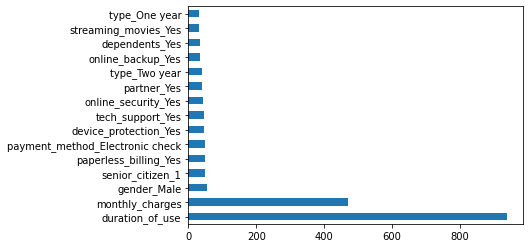

In [50]:
# выведем показатели важности признаков
feat_importances = pd.Series(best_booster.feature_importances_, index=X_test.columns)
feat_importances.nlargest(15).plot(kind='barh');

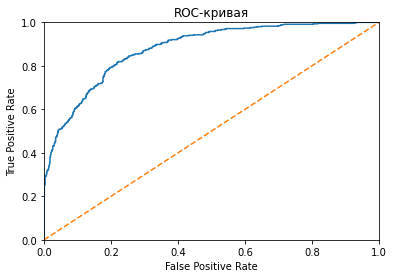

In [51]:
# построим ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, prob_test)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

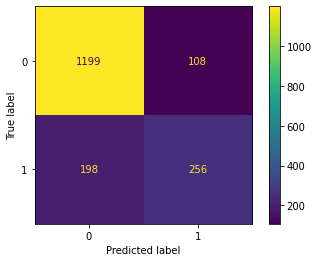

In [52]:
# выведем матрицу ошибок
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, pred))
disp.plot()
plt.show();

На тестовой выборке модель показала метрику AUC_ROC 0.88, что выше целевого значения. 

## Отчет

Целью проекта было создание модели, предсказывающую угрозу оттока клиентов компании «Ниединогоразрыва.ком».  Предполагается, что клиентам, планирующим уйти, будут предложены промокоды и специальные условия. Исходя из этого метрикой качества модели являтеся AUC_ROC, поскольку для задачи важно как не дать лишние скидки клиентам, которые не планируют уходить, так и удержать клиентов.

<b>Целевое значение метрики - от 0.85.</b>

План работы:

1. Анализ данных: распределение, наличие выбросов, мулитиколлинеарность и  наличие дисбаланса. Визуализация данных.

2. Создание и проверка моделей:
- случайный лес;
- линейная регрессия;
- градиентный бустинг.

3. Выбор модели с наилучшей метрикой AUC_ROC, проверка ее на тестовой выборке. Анализ важности признаков.

Всего для анализа было представлено есть 7043 объекта,  распределенные на 4 выборки:
1. Информация о договоре. содержит данные о начале пользования услугами и о конце пользования услугами (на основе этих данных определяется целевой признак). Также есть данные о типе и способе оплаты, об  общих и ежемесячных  тратах.
2. Персональные данные клиента. содержат иформацию о поле, о наличии супруга и иждевенцев, о наличии пенсионного статуса.
3. Информация об используемых интернет-услугах (5517 наблюдений).  Тип подключения и факт использования одной из 6 дополнительных услуг.
4. Информация об используемых услугах телефонии (6361 наблюдений). Факт подключения к услуге параллельных линий.

В выборке представлены данные о подключениях с конца 2013 по начало 2020 года, помесячно. Данные об отключениях есть за 4 даты с конца 2019 года.

Дубликаты не обнаружены. Обнаружены пропуски в колонке с общими расходами, их  заполнили значением колонки ежемесячный рсходы, поскольку данные были не указаны для клиентов, которые подключились в месяце, в котором произведена выгрузка данных. Пропуски для клиентов, которые не используют интернет-услуги  или услуги телефонии, заполнили индикаторным значением.

Мы построили диаграммы размаха для данных о тратах клиентов за месяц и за весь период, выбросы не обнаружены. За месяц клиент тратит от 20 до 120 долларов. Большое количество клиентов тратит примерно 20 долларов в месяц. 

Есть большое количество подключившихся клиентов в начале и в конце периода, за который представлены данные. В середине периода подключались приимерно равномерно, к концу появилась тенденция ростаа количества подключившихся.

Мы создали новые  признаки: пользуется ли клиент телефонией и интернет-услугами, продолжительность пользования услугами.

Анализ данных показывает зависимость между длительностью пользования услугами и фактом отключения: старые клиенты отключаются реже. 

Ежемесячный платеж клиентов, которые пользуются интернет-услугами, предсказуемо выше. Такие клиенты чаще отключаются в начале пользования услугами. В целом процент отключений выше среди тех, кто платит в месяц больше.

Очевидная корреляция, которую выявил анализ, - это корреляция между длительностью использования и общими платежами.

Анализ распределения отключившхся клиентов по категориальным признакам показывает, что чаще отключаются клиенты с помесячной оплатой, клиенты, которые используют электронные платежные документы и электронные чеки. Большой процент отключений среди пенсионеров. Чаще отключаются люди, у которых нет супругов и иждевенцев. Что касается отключений среди клиентов, которые пользуются интернет-услугами, то чаще отключаются те, которые подключены по оптоволоконному кабелю. Поключение к одной из дополнительных услуг является удерживающим клиента фактором.

Мы вычислили долю отключившихся среди пользователей интернет-услуг (32%) и услуг телефонии (27%).

В представленной выборке классы не сбалансированы. 73% наблюдений относятся к отрицательному классу (не отключились). Но так как метрикой качества модели являтется  AUC_ROC, которая предсказывает вероятность классов, а для данной метрики дисбаланс не критичен, то при построении моделей мы не использовали методы борьбы с дисбалансом.

Мы исключили из выборки признаки с сильно коррелированные признаки, в итоге при обучении моделей использовались следующие признаки:
- тип оплаты: ежемесячный, годовой, двухгодовой;
- использование электронного платежного документа;
- способ оплаты: банковский перевод, кредитная карта, электронный чек или чек по почте;
- ежемесячный платеж;
- пол;
- наличие статуса пенсионера;
- наличие супруга;
- наличие иждевенцев;
- подключение к интеренту через телефонную линию или оптоволоконный кабель;
- использование услуги "блокировка небезопасный сайтов";
- использование услуги "облачное хранилище файлов";
- использование услуги "антивирус";
- использование услуги "техническая поддержка";
- использование услуги "стримминоговое ТВ";
- использование услуги "Каталог фильмов";
- использование услуги "Параллельные телефонные линии";
- период использования.

Для кодирования категориальных  признаков мы использовали OHE. Провели нормализацию числовых признаков.

Мы разделили выборку на тренировочную и тестовую  части (тестовая  часть - 25%).

Мы построили 3 модели:
- логистическая регрессия;
- случайный лес с подбором гиперпараметров;
- градиентный бустинг  с подбором гиперпараметров.

Гиперпараметры подбирали с помощью RandomizedSearchCV. Лучшую модель выбирали на кросс-валидации.

Лучшиие результаты показала модель градиентного бустинга. Метрика AUC_ROC лучшей модели на кросс-валидации - 0.9. Параметры лучшей модели: n_estimators: 70, max_depth: 12, random_state: 270223.

На тестовой выборке модель показала метрику <b>AUC_ROC 0.88</b>, что выше целевого значения. 

Наиболее важными при обучении модели были  признаки: период использования и ежемесячный платеж. На этапе анализа мы также отмечали важность этих признаков: чаще отключаются в начале использования, чаще отключаются клиенты с большим месячным платежом.

Матрица ошибок показала, что модель практически   в 2 раза чаще совершает ошибку второго рода (ложноотрицательное  заключение - клиент не отключится, на самом деле он отключился) - 198 случаев, относительно ошибки первого рода (ложноположительное заключение) - 108 случаев.

Можно  заключить, что составленный план работы выполнен полностью, его выполнение привело к достижению поставленной цели. Во  время работы существенных трудностей не возникало, так как данные представлены в хорошем качестве. Единственным видом пропусков, имеющихся в данных изначально были пропуски в признаке "общие расходы" для клиентов, подключившихся в  месяце выгрузки отчета. Мы заполнили эти  пропуски  данными о  месячном платеже такого клиента, предлагаем внедрить такое заполнение на этапе работы с баазой данных. Данные были выгружены в некорректных типах: даты, категории и общая сумма платежей распознавались как строки, такое заполнение может привести к ошибкамм в базе и, следовательно, к некорректному аналиу и предсказанию.